In [1]:
import sys 
sys.path.append('..')

In [2]:
import time


def time_decorator(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        duration = end - start
        print(f"{round(duration,2)} seconds: {func.__name__}")
        return result

    return wrapper

In [3]:
import warnings

warnings.filterwarnings(action="ignore", category=UserWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

import os
from PIL import Image
from functools import lru_cache

from typing import List, Tuple


# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import (
    clean_state_dict,
    get_phrases_from_posmap,
)
import torch
import torchvision
from segment.utils import get_device


DEVICE = get_device()

CURDIR = os.getcwd()

WEIGHTS_DIR = os.path.join(CURDIR, "..", "weights")

# Dino
DINO_DIR = os.path.join(CURDIR, "..", "GroundingDINO")
DINO_CHECKPOINT = os.path.join(WEIGHTS_DIR, "groundingdino_swint_ogc.pth")
DINO_CONFIG = os.path.join(DINO_DIR, "groundingdino/config/GroundingDINO_SwinT_OGC.py")


def caption_handler(caption: str, images: torch.Tensor) -> List[str]:
    """
    Process a single caption for multiple images represented as a tensor.

    Args:
    caption (str): The caption to be processed.
    images (torch.Tensor): A tensor of images.

    Returns:
    List[str]: A list of processed captions, one for each image in the tensor.

    Raises:
    ValueError: If the caption is empty or images tensor is empty.
    TypeError: If images is not a torch.Tensor.
    """
    if not caption:
        raise ValueError("Caption cannot be empty.")
    if not isinstance(images, torch.Tensor):
        raise TypeError("Images must be a torch.Tensor.")
    if images.numel() == 0:
        raise ValueError("Images tensor cannot be empty.")

    processed_caption = caption.lower().strip()
    if not processed_caption.endswith("."):
        processed_caption += "."

    num_images = images.size(0)  # Assuming the first dimension is the number of images
    return [processed_caption] * num_images


def load_dino_model(
    config_path: str, checkpoint_path: str, device: torch.device
) -> torch.nn.Module:
    """
    Load and initialize the grounding model.

    Args:
        config_path (str): Path to the model configuration file.
        checkpoint_path (str): Path to the model checkpoint file.
        device (torch.device): Device to load the model onto.

    Returns:
        torch.nn.Module: The loaded and initialized model.
    """
    args = SLConfig.fromfile(config_path)
    args.device = device

    model = build_model(args)
    checkpoint = torch.load(checkpoint_path, map_location="cpu")

    load_result = model.load_state_dict(
        clean_state_dict(checkpoint["model"]), strict=False
    )
    print(f"Model loading result: {load_result}")

    model.eval()
    return model.to(device)


@lru_cache(maxsize=1)
def get_dino_model() -> torch.nn.Module:
    """
    Get the GroundedDINO model, using caching to avoid reloading.

    Returns:
        torch.nn.Module: The loaded grounding model.
    """
    return load_dino_model(DINO_CONFIG, DINO_CHECKPOINT, DEVICE)


def transform_image_dino(image_pil: Image.Image) -> torch.tensor:

    transform = T.Compose(
        [
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image, _ = transform(image_pil, None)  # 3, h, w
    return image

# @time_decorator
# def run_dino(dino_model, images, caption, box_threshold=0.3, **kwargs):
#     processed_captions = caption_handler(caption, images)

#     # Ensure images is a batch (first dimension is batch size)
#     if len(images.shape) == 3:
#         images = images.unsqueeze(0)

#     with torch.no_grad():
#         # Obtain model outputs for the batch of images and captions
#         outputs = dino_model(images, captions=processed_captions)

#     prediction_logits = (
#         outputs["pred_logits"].cpu().sigmoid()
#     )  # prediction_logits.shape = (num_batch, nq, 256)
#     prediction_boxes = outputs[
#         "pred_boxes"
#     ].cpu()  # prediction_boxes.shape = (num_batch, nq, 4)

#     # import ipdb; ipdb.set_trace()
#     mask = prediction_logits.max(dim=2)[0] > box_threshold


#     bboxes_batch = []
#     predicts_batch = []
#     phrases_batch = []  # list of lists
#     tokenizer = dino_model.tokenizer
#     tokenized = tokenizer(caption)
#     for i in range(prediction_logits.shape[0]):
#         logits = prediction_logits[i][mask[i]]  # logits.shape = (n, 256)
#         phrases = [
#             get_phrases_from_posmap(
#                 logit == torch.max(logit), tokenized, tokenizer
#             ).replace(".", "")
#             for logit in logits  # logit is a tensor of shape (256,) torch.Size([256])  # torch.Size([7, 256])
#         ]
#         boxes = prediction_boxes[i][mask[i]]  # boxes.shape = (n, 4)
#         phrases_batch.append(phrases)
#         bboxes_batch.append(boxes)
#         predicts_batch.append(logits.max(dim=1)[0])

#     return bboxes_batch, predicts_batch, phrases_batch


def run_dino(
    dino_model, images, caption: str, box_threshold: float = 0.3, **kwargs
) -> Tuple[List[torch.Tensor], List[torch.Tensor], List[List[str]]]:
    processed_captions = caption_handler(caption, images)

    # Ensure images is a batch (first dimension is batch size)
    images = images.unsqueeze(0) if len(images.shape) == 3 else images

    with torch.no_grad():
        outputs = dino_model(images, captions=processed_captions)

    prediction_logits = outputs["pred_logits"].cpu().sigmoid()
    prediction_boxes = outputs["pred_boxes"].cpu()

    mask = prediction_logits.max(dim=2)[0] > box_threshold

    tokenizer = dino_model.tokenizer
    tokenized = tokenizer(caption)

    # Vectorized operations
    batch_logits = [logits[m] for logits, m in zip(prediction_logits, mask)]
    batch_boxes = [boxes[m] for boxes, m in zip(prediction_boxes, mask)]

    # Compute max logits once
    max_logits = [logits.max(dim=1) for logits in batch_logits]
    predicts_batch = [max_logit.values for max_logit in max_logits]

    phrases_batch = [
        [
            get_phrases_from_posmap(logit == max_val, tokenized, tokenizer).replace(
                ".", ""
            )
            for logit, max_val in zip(batch_logit, max_logit.values)
        ]
        for batch_logit, max_logit in zip(batch_logits, max_logits)
    ]

    return batch_boxes, predicts_batch, phrases_batch


def format_dino(
    batch_boxes_filt,
    batch_scores,
    batch_pred_phrases,
    image_size=(1024, 1024),
    iou_threshold=0.8,
):
    batch_final_boxes = []
    batch_final_scores = []
    batch_final_phrases = []

    # Process each item in the batch
    for boxes_filt, scores, pred_phrases in zip(
        batch_boxes_filt, batch_scores, batch_pred_phrases
    ):
        # Adjust box coordinates based on image size
        H, W = image_size[1], image_size[0]
        for i in range(boxes_filt.size(0)):
            boxes_filt[i] = boxes_filt[i] * torch.Tensor([W, H, W, H])
            boxes_filt[i][:2] -= boxes_filt[i][2:] / 2
            boxes_filt[i][2:] += boxes_filt[i][:2]

        # Non-maximum suppression (NMS)
        nms_idx = (
            torchvision.ops.nms(boxes_filt, scores, iou_threshold).numpy().tolist()
        )
        final_boxes = boxes_filt[nms_idx]
        final_scores = scores[nms_idx]
        final_phrases = [pred_phrases[idx] for idx in nms_idx]

        # Collect results for this batch element
        batch_final_boxes.append(final_boxes)
        batch_final_scores.append(final_scores)
        batch_final_phrases.append(final_phrases)

    return batch_final_boxes, batch_final_scores, batch_final_phrases


class DinoResults:
    def __init__(self, boxes, scores, phrases):
        self.boxes = boxes
        self.scores = scores
        self.phrases = phrases


def get_dino_results(
    images: List[Image.Image],
    text_prompt: str,
    device: torch.device,
    box_threshold=0.3,
    text_threshold=0.25,
    iou_threshold=0.8,
) -> DinoResults:
    """
    Run the DINO model on an image and text prompt.

    Args:
    image (Image.Image): A list of images to process.
    text_prompt (str): The text prompt to use.
    device (torch.device): The device to run the model on.
    box_threshold (float): The box threshold.
    text_threshold (float): The text threshold.
    iou_threshold (float): The IoU threshold.

    Returns:
    tuple: A tuple containing the boxes, scores, and phrases.
    """

    # Load DINO model
    dino_model = get_dino_model()

    dino_images = torch.stack([transform_image_dino(image) for image in images])
    dino_images = dino_images.to(device)

    # Process with DINO model
    boxes, scores, phrases = run_dino(
        dino_model, dino_images, text_prompt, box_threshold
    )
    boxes, scores, phrases = format_dino(
        boxes, scores, phrases, iou_threshold=iou_threshold
    )
    results = DinoResults(boxes, scores, phrases)
    return results

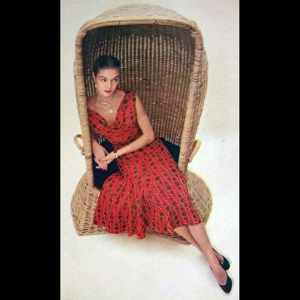

In [4]:
from pathlib import Path
from PIL import Image
from segment.utils import resize_image_pil


def load_image(image_path):
    image_pil = Image.open(image_path).convert("RGB")
    image_pil = resize_image_pil(image_pil, 1024)
    return image_pil


image_dir = Path("../datasets/fashion_people_detection/images/val")
image_paths = list(image_dir.glob("*.jpg"))

images = [load_image(path) for path in image_paths[:20]]

results = get_dino_results(images, "legs", DEVICE)
print(f"Boxes: {results.boxes}")
print(f"Scores: {results.scores}")
print(f"Phrases: {results.phrases}")


In [10]:
results = get_dino_results(images, "legs", DEVICE)

1.49 seconds: run_dino


: 

In [ ]:
2.09 seconds: run_dino

In [6]:
results.boxes

[tensor([[ 591.6728,  753.7534,  793.6195, 1001.7125]]),
 tensor([[ 346.2973,  389.5279,  527.7189, 1006.5432],
         [ 490.4406,  343.6061,  769.8213, 1014.5494]]),
 tensor([[2.1794e+02, 7.0942e+02, 5.1312e+02, 1.0227e+03],
         [1.4621e+02, 9.7726e-01, 9.0014e+02, 1.0218e+03]]),
 tensor([[ 518.0842,  556.4009,  615.0497,  993.9971],
         [ 426.4284,  545.1504,  547.2415, 1018.1031],
         [ 425.5099,  537.5361,  616.7296, 1017.8897]]),
 tensor([[ 498.4678,  898.0612,  610.6458, 1022.9763],
         [ 341.6025,  937.8364,  473.1196, 1023.0292],
         [ 341.1099,  896.4297,  612.7770, 1022.8888]]),
 tensor([[336.7992, 380.6943, 752.5594, 995.0865],
         [318.7986,  31.0038, 753.7502, 995.0930]]),
 tensor([[ 169.2821,   66.2119,  854.6962, 1022.3786],
         [ 169.8206,  548.7981,  852.4735, 1022.5781]]),
 tensor([[ 125.9062,  314.9834,  434.2642,  973.0144],
         [ 126.2266,   40.3068,  638.8826, 1021.9647]]),
 tensor([[485.2033, 646.9421, 575.1235, 984.7887]